In [1]:
import torch
from torch.utils.data import DataLoader
import sys
from plyfile import PlyData
import numpy as np
from tqdm import tqdm
from glob import glob
from os import path
sys.path.append('../')
from pointnet.dataset import OctantDataset, collate_batched_point_clouds, lm2flat_index
from pointnet.metrics import camera_color
from pointnet.sh import to_spherical,calc_sh

/home/niedermayr/anaconda3/envs/punctum12/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def camera_positions(filename: str) -> torch.Tensor:
    plydata = PlyData.read(filename)
    vertex_data = plydata["vertex"].data

    def unpack_data(data, field_names):
        return torch.from_numpy(np.stack([data[key] for key in field_names]).T)

    cameras = unpack_data(vertex_data, ["x", "y", "z"])
    return to_spherical(cameras)

cameras_pos = camera_positions("../sphere.ply")
cameras_pos.shape

torch.Size([162, 2])

In [118]:
def color_error_for_dataset(ds_path:str):
    batch_size = 64

    ds = OctantDataset(ds_path,load_cam_colors=True)

    data_loader = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=6,
        collate_fn=collate_batched_point_clouds,
        pin_memory=False,
        drop_last=False,
        prefetch_factor=10,
        pin_memory_device="cuda:0",
    )
    l_max = 10
    y = calc_sh(l_max,cameras_pos).cuda()
    error =torch.empty((len(ds),l_max+1,len(cameras_pos)),device="cuda:0")
    for i,sample in tqdm(enumerate(data_loader),total=len(data_loader)):
        coefs = sample.coefs.cuda()
        cam_colors = sample.cam_colors.cuda()
        for l in range(l_max+1):
            max_index = lm2flat_index(l,l)+1
            d_colors = y[:,:max_index]@coefs[:,:max_index]
            error[i*batch_size:((i+1) * batch_size),l] = (d_colors - cam_colors).norm(2,2)

    return error.cpu()

In [119]:
dataset_paths = glob("../datasets/*/octants_8192max_sh")
ds_stats = {ds:color_error_for_dataset(ds) for ds in dataset_paths}

/home/niedermayr/anaconda3/envs/punctum12/lib/python3.10/site-packages/torch/utils/data/dataloader.py:616: UserWarning: pin memory device is set and pin_memory flag is not used then device pinned memory won't be usedplease set pin_memory to true, if you need to use the device pin memory
  warnings.warn(warn_msg)
 70%|██████▉   | 480/690 [00:29<00:12, 16.90it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7e5f1640d0>
Traceback (most recent call last):
  File "/home/niedermayr/anaconda3/envs/punctum12/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/home/niedermayr/anaconda3/envs/punctum12/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/home/niedermayr/anaconda3/envs/punctum12/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child p

In [121]:
import json
with open("ds_error.json","w") as f:
    json.dump({name:values.tolist() for name,values in ds_stats.items()},f)

KeyboardInterrupt: 

In [129]:
ds_stats['../datasets/kaiserburg/octants_8192max_sh'].mean([0,2]).shape

torch.Size([11])

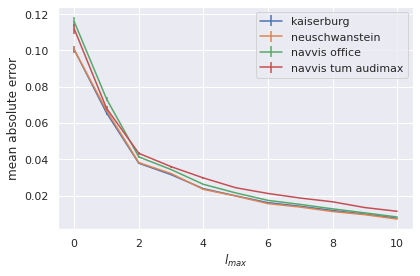

In [161]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
for name,values in ds_stats.items():
    per_l =  values.permute(1,0,2).flatten(1)
    worst = per_l.topk(per_l.shape[1]//10,1).values
    mean =worst.mean(1)
    var = worst.var(1)
    plt.errorbar(np.arange(10+1),mean,yerr=var,label=name.split("/")[-2].replace("_"," "))


#plt.hlines([5/255],[0],[10],linestyles="dotted")
plt.xlabel("$l_{max}$")
plt.ylabel("mean absolute error")
plt.legend()
plt.tight_layout()
plt.savefig("l_max_error.pdf")